In [14]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [37]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import time
from sklearn.model_selection import train_test_split
from scipy import stats


In [16]:
# df_numeric = pd.read_csv('/content/drive/MyDrive/DKE/project 1-1/auto_data.csv',index_col=0)
# print("sample nb= ",len(df_numeric))
# print("vars nb= ",len(df_numeric.columns))
df = pd.read_csv('/content/drive/MyDrive/DKE/project 1-1/SHR76_20.csv',index_col=0) 
print("sample nb= ",len(df))
print("vars nb= ",len(df.columns))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


sample nb=  827219
vars nb=  30


In [17]:
# Feature Cleaning
df.insert(1, 'County', df['CNTYFIPS'].map(lambda x : str(x).split(',')[0]), True)
df.drop("CNTYFIPS",axis = 1, inplace= True) # redundant, onlyy keeping the county part
df.drop("StateName",axis = 1, inplace= True)  # redundant, contains state
df.drop("Ori",axis = 1, inplace= True)  # redundant, contains state + county + agentcy nb
df.insert(3, 'Area',df['MSA'].map(lambda x :  str(x).split(',')[0] ) ,True)
df.drop('MSA',axis = 1,inplace=True) # rendundant only the state, keeping the metropolitant statistical area
df['OffAge'].replace(999, np.NaN, inplace=True) # replacing 999 ages with Nan

# split File Date in Day-Month-Year columns
nan_indexes = df["FileDate"].isna()
df['FileDate'].fillna(0,inplace = True)
df['FileDate'] = df['FileDate'].astype(int)
df['FileDate'] = df['FileDate'].astype(str)
df.insert(1, 'File Year', df['FileDate'].map(lambda x : x[len(x)-2:len(x)]), True)
df.insert(1, 'File Day', df['FileDate'].map(lambda x : x[len(x)-4:len(x)-2]), True)
df.insert(1, 'File Month', df['FileDate'].map(lambda x : x[0:len(x)-4]), True)
df.loc[nan_indexes,"File Year"] = np.NaN
df.loc[nan_indexes,"File Day"] = np.NaN
df.loc[nan_indexes,"File Month"] = np.NaN
df.drop("FileDate",axis = 1,inplace = True)

df.drop("Incident",axis = 1,inplace = True) # incient number of the month, for a specific county useless for our application

df.drop("Situation",axis = 1,inplace = True) # redundant, info already contained in OffCount and VicCount

# drop source ?

In [18]:
print(df[:].isnull().sum().sort_values(ascending = False))

Subcircum       794768
OffAge          274871
File Month        2510
File Day          2510
File Year         2510
OffCount             0
ActionType           0
State                0
Agency               0
Area                 0
Agentype             0
Source               0
Solved               0
Year                 0
Month                0
Homicide             0
VicCount             0
VicAge               0
VicSex               0
VicRace              0
VicEthnic            0
OffSex               0
OffRace              0
OffEthnic            0
Weapon               0
Relationship         0
Circumstance         0
County               0
dtype: int64


In [19]:
# df_sub = df
# if i do not drop Subcircum -> i get to only 12.000 data. Worth it?
df_sub = df.drop(["Subcircum",'File Month','File Year','File Day'],axis = 1)

print(len(df_sub))
df_sub_full = df_sub.dropna()
print(len(df_sub_full))

for col in df_sub.columns:
    try:
        df_sub_full = df_sub_full[df_sub_full[col].str.contains("nknown|undetermined|not specified",regex = True)==False]
    except:
            a=0
print(len(df_sub_full))

827219
552348
185516


In [20]:
df_numeric = df_sub_full.copy(deep=True)

for col in df_sub_full.columns:
  # if(col in ['File Month','File Year','File Day']):
  #   df_numeric[col] = pd.to_numeric(df[col])
  #   print(col)
  if df[col].dtype == 'object':
    labels = df_numeric[col].unique().tolist()
    mapping = dict( zip(labels,range(len(labels))) )
    df_numeric.replace({col: mapping},inplace=True)

In [21]:
df_numeric.dtypes

County            int64
State             int64
Agency            int64
Area              int64
Agentype          int64
Source            int64
Solved            int64
Year              int64
Month             int64
ActionType        int64
Homicide          int64
VicAge            int64
VicSex            int64
VicRace           int64
VicEthnic         int64
OffAge          float64
OffSex            int64
OffRace           int64
OffEthnic         int64
Weapon            int64
Relationship      int64
Circumstance      int64
VicCount          int64
OffCount          int64
dtype: object

In [22]:
df.head(10)

,County,File Month,File Day,File Year,State,Agency,Area,Agentype,Source,Solved,Year,Month,ActionType,Homicide,VicAge,VicSex,VicRace,VicEthnic,OffAge,OffSex,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
197609001AL00400,Autauga,3,01,80,Alabama,Autauga County,Montgomery,Sheriff,FBI,No,1976,September,Normal update,Murder and non-negligent manslaughter,30,Male,Black,Unknown or not reported,NaN,Unknown,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,Other,NaN,0,0
197701001AL00400,Autauga,3,01,80,Alabama,Autauga County,Montgomery,Sheriff,FBI,Yes,1977,January,Normal update,Murder and non-negligent manslaughter,65,Female,Black,Unknown or not reported,62.0,Male,Black,Unknown or not reported,Other or type unknown,Acquaintance,Brawl due to influence of alcohol,NaN,0,0
197703001AL00400,Autauga,3,01,80,Alabama,Autauga County,Montgomery,Sheriff,FBI,Yes,1977,March,Normal update,Murder and non-negligent manslaughter,48,Male,White,Unknown or not reported,52.0,Male,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Acquaintance,Other arguments,NaN,0,1
197703001AL00401,Autauga,3,01,80,Alabama,Prattville,Montgomery,Municipal police,FBI,Yes,1977,March,Normal update,Murder and non-negligent manslaughter,27,Male,Black,Unknown or not reported,22.0,Female,Black,Unknown or not reported,Shotgun,Husband,Other arguments,NaN,0,0
197708001AL00400,Autauga,3,01,80,Alabama,Autauga County,Montgomery,Sheriff,FBI,Yes,1977,August,Normal update,Murder and non-negligent manslaughter,17,Female,Black,Unknown or not reported,21.0,Male,Black,Unknown or not reported,Knife or cutting instrument,Acquaintance,Circumstances undetermined,NaN,0,0
197710001AL00400,Autauga,3,01,80,Alabama,Autauga County,Montgomery,Sheriff,FBI,Yes,1977,October,Normal update,Murder and non-negligent manslaughter,62,Male,Asian,Unknown or not reported,80.0,Male,Black,Unknown or not reported,Shotgun,Stranger,Robbery,NaN,0,0
197805001AL00400,Autauga,3,01,80,Alabama,Autauga County,Montgomery,Sheriff,FBI,Yes,1978,May,Normal update,Murder and non-negligent manslaughter,54,Male,Black,Unknown or not reported,54.0,Female,Black,Unknown or not reported,Knife or cutting instrument,Husband,Circumstances undetermined,NaN,0,2
197812001AL00400,Autauga,3,01,80,Alabama,Autauga County,Montgomery,Sheriff,FBI,Yes,1978,December,Normal update,Murder and non-negligent manslaughter,48,Female,White,Unknown or not reported,26.0,Male,White,Unknown or not reported,"Blunt object - hammer, club, etc",Acquaintance,Other,NaN,0,0
197902001AL00400,Autauga,3,01,80,Alabama,Autauga County,Montgomery,Sheriff,FBI,No,1979,February,Normal update,Murder and non-negligent manslaughter,999,Female,Unknown,Unknown or not reported,NaN,Unknown,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,Circumstances undetermined,NaN,0,0


In [23]:
df_numeric.head(10)

,County,State,Agency,Area,Agentype,Source,Solved,Year,Month,ActionType,Homicide,VicAge,VicSex,VicRace,VicEthnic,OffAge,OffSex,OffRace,OffEthnic,Weapon,Relationship,Circumstance,VicCount,OffCount
ID,,,,,,,,,,,,,,,,,,,,,,,,
198101001AL00401,0,0,0,0,0,0,0,1981,0,0,0,67,0,0,0,21.0,0,0,0,0,0,0,0,0
198212001AL00401,0,0,0,0,0,0,0,1982,1,0,0,28,0,0,1,20.0,0,0,1,1,1,1,0,0
198212002AL00401,0,0,0,0,0,0,0,1982,1,0,0,27,0,1,1,44.0,0,1,1,1,2,1,0,0
198302001AL00401,0,0,0,0,0,0,0,1983,2,1,0,16,0,0,1,17.0,0,0,1,0,0,1,0,0
198308001AL00400,0,0,1,0,1,0,0,1983,3,0,0,25,0,1,1,29.0,1,1,1,1,3,1,0,0
198312001AL00401,0,0,0,0,0,0,0,1983,1,0,0,55,1,0,1,55.0,0,0,1,2,4,1,0,0
198401001AL00400,0,0,1,0,1,0,0,1984,0,0,0,24,1,1,1,23.0,0,1,1,0,4,0,0,0
198410001AL00400,0,0,1,0,1,0,0,1984,4,0,0,34,0,0,1,58.0,0,0,1,1,1,0,0,0
198504001AL00400,0,0,1,0,1,0,0,1985,5,0,0,38,0,0,1,45.0,0,1,1,0,0,2,0,0


In [24]:
df_numeric.to_csv('/content/drive/MyDrive/DKE/project 1-1/auto_data.csv')

input dim =  24
hidden layer size =  9
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
36.09816813468933  sec
outliers nb:  8255
hidden layer size =  10
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
42.45932197570801  sec


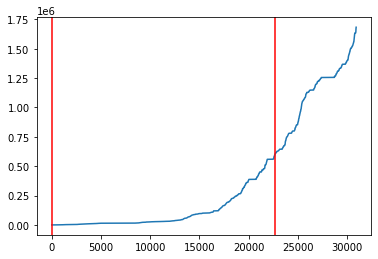

outliers nb:  1945
hidden layer size =  11
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
42.528902769088745  sec


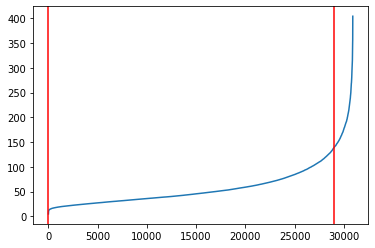

outliers nb:  9189
hidden layer size =  12
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
17.605883598327637  sec


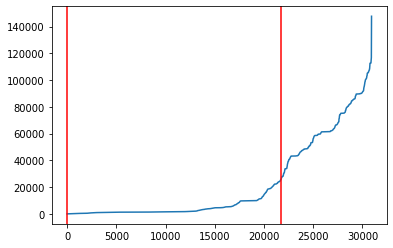

outliers nb:  8255
hidden layer size =  13
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
30.430532693862915  sec


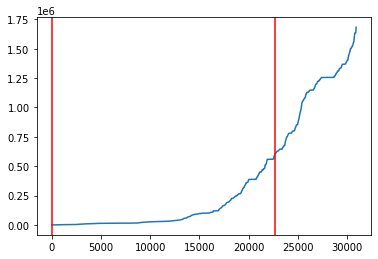

outliers nb:  0
hidden layer size =  14
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
16.119153261184692  sec


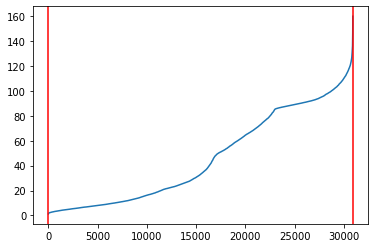

outliers nb:  10362
hidden layer size =  15
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
27.80446481704712  sec


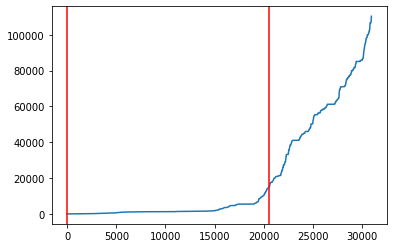

outliers nb:  8243
hidden layer size =  16
Restoring model weights from the end of the best epoch.
Epoch 00068: early stopping
45.45595121383667  sec


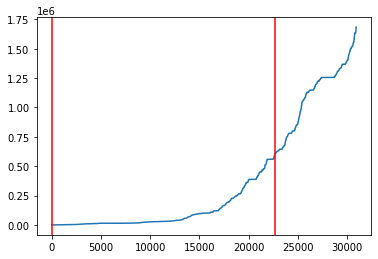

outliers nb:  1944
hidden layer size =  17
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
28.69061517715454  sec


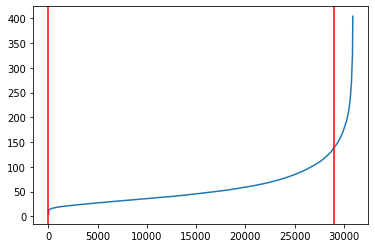

outliers nb:  1
hidden layer size =  18
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
31.072274684906006  sec


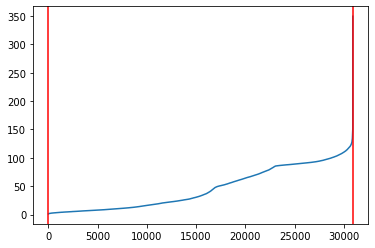

outliers nb:  10430
hidden layer size =  19
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
24.56474280357361  sec


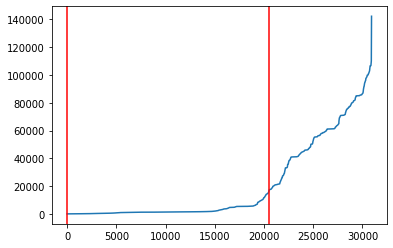

outliers nb:  222
hidden layer size =  20
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
40.993189573287964  sec


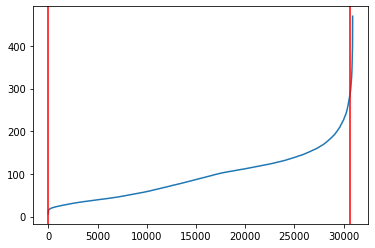

outliers nb:  0
hidden layer size =  21
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
44.295079708099365  sec


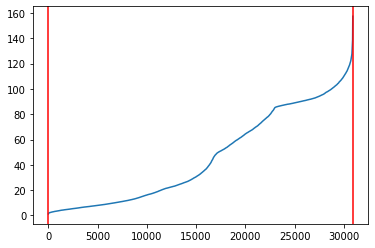

outliers nb:  7059
hidden layer size =  22
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
32.67668914794922  sec


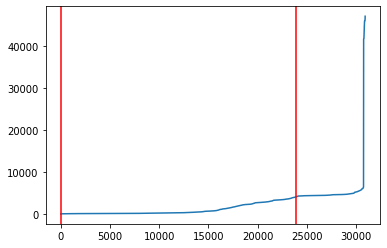

outliers nb:  10334


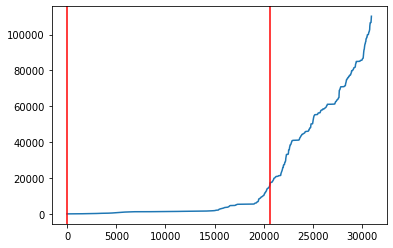

In [52]:
def get_outliers(scores, mad = True):
    # set a statistical threshold
    thresh = 3.5
    
    mean =  np.mean(scores)
    med = np.median(scores)
    std = np.std(scores)

#   mad score:  https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm
    if mad:
        ad = np.abs(scores - med)
        mad = np.median(ad)
        zscores =  0.6745 * (scores - med) / mad
    else:
        zscores = (scores-mean)/std

            
    z_idx1 = (np.abs(zscores - thresh)).argmin()
    z_idx2 = (np.abs(zscores + thresh)).argmin()

    idx = scores[z_idx1]
    idx2 = scores[z_idx2]

#   histogram distribution plot
    # fig, ax = plt.subplots()
    # plt.hist(scores, bins = 100)
    # plt.axvline(x=idx,c = 'r')
    # plt.axvline(x=idx2,c = 'r')

    plt.show()
    return (idx, idx2, np.where(np.abs(zscores) >= thresh))
    
def build_outliers(scores, method_name, mad = True):
    val1, val2, outlier_index = get_outliers(scores, mad)
    idx = (np.abs(sorted(scores) - val1)).argmin()
    idx2 = (np.abs(sorted(scores) - val2)).argmin()

    fig, ax = plt.subplots()
    plt.plot(sorted(scores))
    plt.axvline(x=idx,c='r')
    plt.axvline(x=idx2,c='r')

    print("outliers nb: ",len(outlier_index[0]))
    nbs.append(len(outlier_index[0]))
    outlier_bool = np.zeros(len(df))
    outlier_bool[outlier_index] = 1.0
    df[method_name] = outlier_bool


X_train, X_test = train_test_split(df_numeric, test_size = int(df_numeric.shape[0]/6))
X_train2, X_val = train_test_split(X_train, test_size = int(X_train.shape[0]/6))

# data dimensions // hyperparameters 
input_dim = X_train.shape[1]
print("input dim = ",input_dim)
BATCH_SIZE = 256
EPOCHS = 100

def build_autoencoder(hidden_size):
  # https://keras.io/layers/core/
  autoencoder = tf.keras.models.Sequential([
      # deconstruct / encode
      tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim,)), 
      tf.keras.layers.Dense(hidden_size, activation='elu'),
      tf.keras.layers.Dense(input_dim, activation='elu')
  ])

  # https://keras.io/api/models/model_training_apis/
  autoencoder.compile(optimizer="adam", 
                      loss="mse",
                      metrics=["acc"])

  early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='loss',
      min_delta=0.0001,
      patience=12,
      verbose=1, 
      mode='min',
      restore_best_weights=True
  )

  tensorboard = tf.keras.callbacks.TensorBoard(
      batch_size=BATCH_SIZE,
      update_freq='batch'
  )

  cb = [early_stop,tensorboard]

  be = time.time()

  history = autoencoder.fit(
      X_train2, X_train2,
      shuffle=True,
      epochs=EPOCHS,
      batch_size=BATCH_SIZE,
      callbacks=cb,
      verbose = 0,
      validation_data=(X_val, X_val)
  );

  autoencoders_time = time.time() - be
  print(autoencoders_time," sec")

  # pass the transformed test set through the autoencoder to get the reconstructed result
  reconstructions = autoencoder.predict(X_test)
  #calculating the mean squared error reconstruction loss per row in the numpy array
  return np.mean(np.power(X_test - reconstructions, 2), axis=1)

nbs = []
names = []
mses = []
for i in range(input_dim-15,input_dim-1):
  print("hidden layer size = ",i)
  names.append("l-"+str(i))
  mse = build_autoencoder(i)
  mses.append(mse)
  build_outliers(mse, "auto-"+str(i) , mad = True)

[8255, 1945, 9189, 8255, 0, 10362, 8243, 1944, 1, 10430, 222, 0, 7059, 10334]


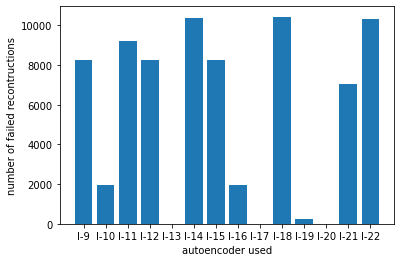

In [53]:
plt.ylabel("number of failed recontructions")
plt.xlabel("autoencoder used")

plt.bar(names,nbs)

print(nbs)

median errors =  [1.00388709e+05 4.65873175e+01 4.64060719e+03 1.00498521e+05
 3.29692772e+01 2.59651571e+03 1.00450522e+05 4.65838734e+01
 3.29792254e+01 2.77305430e+03 8.95063100e+01 3.29699056e+01
 7.16249333e+02 2.63886832e+03]
trimmed mean errors =  [2.56418371e+05 5.05371473e+01 1.44528529e+04 2.56708689e+05
 4.28081143e+01 1.25967643e+04 2.56398092e+05 5.05247115e+01
 4.28174098e+01 1.29156323e+04 8.87734122e+01 4.28051689e+01
 1.55451791e+03 1.26200523e+04]


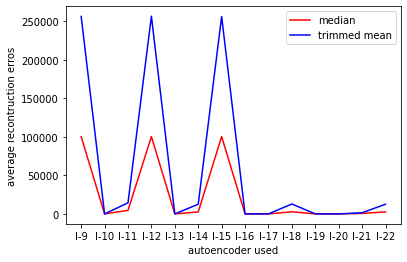

In [55]:
trim = stats.trim_mean(mses, 0.15,axis = 1)
med = np.median(mses, axis = 1)

print("median errors = ",med)
print("trimmed mean errors = ",trim)

plt.ylabel("average recontruction erros")
plt.xlabel("autoencoder used")
plt.plot(names,med,'r',label ="median")
plt.plot(names,trim,'b',label ="trimmed mean")
plt.legend()